<a href="https://colab.research.google.com/github/SunilkumarAdapa/RLQ-learningTradingAI/blob/main/Trading_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#install the tensorflow:
!pip install tensorflow

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from pandas_datareader import data as pdr
from collections import deque
import random
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

In [8]:
#processing libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [10]:
# Load the data
data = pd.read_csv(r'/content/Data/NTPC.NS (1).csv')

In [11]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-10-08,134.500000,137.416672,132.875000,136.208328,102.523041,4637569
1,2018-10-09,137.333328,137.500000,134.083328,134.750000,101.425362,5756458
2,2018-10-10,134.750000,138.875000,134.375000,136.958328,103.087570,3411681
3,2018-10-11,135.000000,138.083328,134.416672,135.958328,102.334885,3668989
4,2018-10-12,136.583328,137.791672,135.875000,136.833328,102.993477,4147903


In [12]:
data.dtypes#here date is object change to time

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [13]:
data['Date']=pd.to_datetime(data['Date'])

In [14]:
data.dtypes#here change to datetime

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [15]:
data.set_index('Date',inplace=True)#here date is set to index
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-10-08,134.500000,137.416672,132.875000,136.208328,102.523041,4637569
2018-10-09,137.333328,137.500000,134.083328,134.750000,101.425362,5756458
2018-10-10,134.750000,138.875000,134.375000,136.958328,103.087570,3411681
2018-10-11,135.000000,138.083328,134.416672,135.958328,102.334885,3668989
2018-10-12,136.583328,137.791672,135.875000,136.833328,102.993477,4147903


In [29]:
df= data.copy()
name = 'Q-learning agent'
class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest,
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [31]:
#train the agent
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size,
              window_size = window_size,
              trend = close,
              skip = skip,
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 2795.708312.3, cost: 0.337085, total money: 1362.908324
epoch: 20, total rewards: 1906.241589.3, cost: 0.173933, total money: 6017.841595
epoch: 30, total rewards: 1567.983309.3, cost: 0.153855, total money: 5993.383318
epoch: 40, total rewards: 1156.083290.3, cost: 0.111007, total money: 6522.633293
epoch: 50, total rewards: 1294.808241.3, cost: 0.115449, total money: 7264.208250
epoch: 60, total rewards: 879.483263.3, cost: 0.098189, total money: 7200.833269
epoch: 70, total rewards: 931.358271.3, cost: 0.077905, total money: 7252.708277
epoch: 80, total rewards: 710.041611.3, cost: 0.071401, total money: 7418.541611
epoch: 90, total rewards: 565.924935.3, cost: 0.084746, total money: 8769.674935
epoch: 100, total rewards: 929.191644.3, cost: 0.062131, total money: 7839.291650
epoch: 110, total rewards: 488.208299.3, cost: 0.087361, total money: 9789.008287
epoch: 120, total rewards: 466.758294.3, cost: 0.059811, total money: 9107.358285
epoch: 130, total re

In [32]:
# test the Agent
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 12: buy 1 unit at price 135.250000, total balance 9864.750000
day 13: buy 1 unit at price 132.750000, total balance 9732.000000
day 14: buy 1 unit at price 132.458328, total balance 9599.541672
day 15, sell 1 unit at price 132.833328, investment -1.786818 %, total balance 9732.375000,
day 16: buy 1 unit at price 133.041672, total balance 9599.333328
day 17: buy 1 unit at price 130.833328, total balance 9468.500000
day 18, sell 1 unit at price 131.666672, investment -0.816066 %, total balance 9600.166672,
day 19: buy 1 unit at price 127.916664, total balance 9472.250008
day 20, sell 1 unit at price 128.458328, investment -3.019818 %, total balance 9600.708336,
day 21, sell 1 unit at price 129.041672, investment -3.006577 %, total balance 9729.750008,
day 22: buy 1 unit at price 128.708328, total balance 9601.041680
day 23: buy 1 unit at price 127.333336, total balance 9473.708344
day 24, sell 1 unit at price 130.666672, investment -0.127380 %, total balance 9604.375016,
day 25, sell

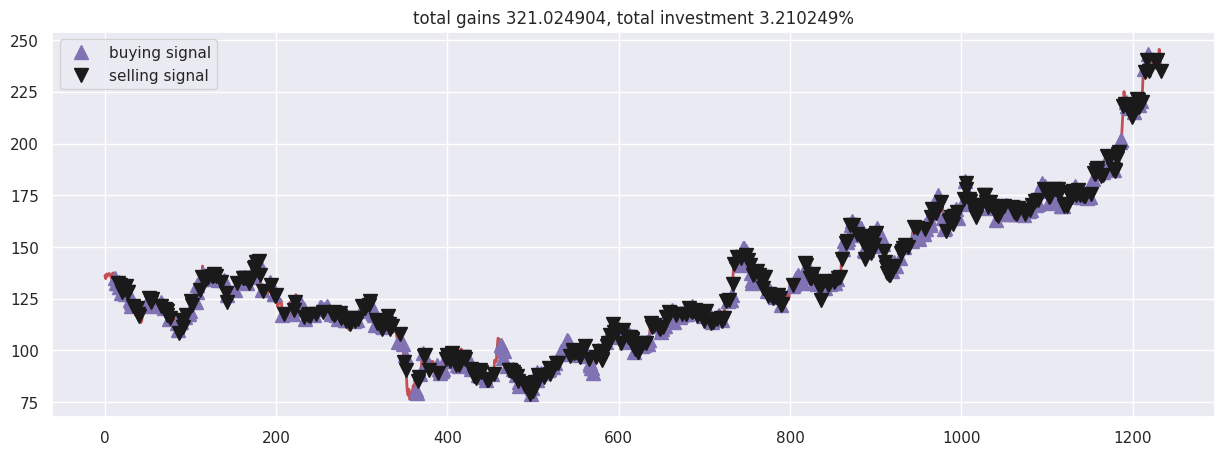

In [33]:
#plot the calls
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()